# DAT 301 Project 2
Jason Kong  
Apr 24, 2024

## Introduction
**Dataset**  
For this project, I will be exploring the same dataset that I used in Project 1, which is the complete laptime data of all drivers from the entire 2023 Formula 1 season that I compiled using FastF1 and `f1dataR` (https://docs.fastf1.dev/).  
  
**Goal**  
Instead of a tire wear visualization, we will modify our calculation model used in Project 1 to compare and visualize the laptime consistency of different drivers.  

Consistency is a very important metric when quantifying a driver's skill in motorsports. An error-prone driver might occasionally produce an impressive fast lap here and there, but over the course of a race, their errors will add up, making them lose out to drivers who are able to produce fast laps consistently.  
  
Throughout the history of Formula 1, all great drivers had the common trait of being incredibly consistent. One of the most notable examples was the seven-time world champion Michael Schumacher, who in the 1998 Hungarian Grand Prix, completed 19 max-attack laps in a row at the request of his race engineer, creating a 25-second gap that allowed him to complete a pitstop and retain the lead.

## Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('2023resultsProj2.csv', index_col = 0)
df

,driver,driver_number,lap_time,lap_number,stint,pit_out_time,pit_in_time,sector1time,sector2time,sector3time,...,lap_start_time,lap_start_date,track_status,position,deleted,deleted_reason,fast_f1generated,is_accurate,session_type,round
time,,,,,,,,,,,,,,,,,,,,,
3855.961,VER,1,99.019,1,1,NaN,NaN,NaN,42.414,23.842,...,3756.652,2023-03-05 07:03:38.501,12.0,1.0,False,NaN,False,False,R,1
3953.935,VER,1,97.974,2,1,NaN,NaN,31.342,42.504,24.128,...,3855.961,2023-03-05 07:05:17.81,12.0,1.0,False,NaN,False,True,R,1
4051.941,VER,1,98.006,3,1,NaN,NaN,31.388,42.469,24.149,...,3953.935,2023-03-05 07:06:55.784,1.0,1.0,False,NaN,False,True,R,1
4149.917,VER,1,97.976,4,1,NaN,NaN,31.271,42.642,24.063,...,4051.941,2023-03-05 07:08:33.79,1.0,1.0,False,NaN,False,True,R,1
4247.952,VER,1,98.035,5,1,NaN,NaN,31.244,42.724,24.067,...,4149.917,2023-03-05 07:10:11.766,1.0,1.0,False,NaN,False,True,R,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8620.213,MAG,20,90.445,53,3,NaN,NaN,18.338,38.718,33.389,...,8529.768,2023-11-26 06:23:10.893,1.0,20.0,False,NaN,False,True,R,22
8710.420,MAG,20,90.207,54,3,NaN,NaN,18.196,38.696,33.315,...,8620.213,2023-11-26 06:24:41.338,1.0,20.0,False,NaN,False,True,R,22
8800.672,MAG,20,90.252,55,3,NaN,NaN,18.187,38.669,33.396,...,8710.420,2023-11-26 06:26:11.545,1.0,20.0,False,NaN,False,True,R,22


## Fuel Load Adjustment
We will use the same `fuel_correction()` function we used in Project 1 to remove fuel weight as a factor of our laptimes.

In [3]:
def fuel_correction(laptime, total_laps, current_lap):
    return laptime - (110 * 0.03) * (1 - current_lap / total_laps)

## Initial Exploration
Again, we are using Max Verstappen's laptimes in round 1 of 2023 to explore how we can build our model.

In [4]:
# Filter our dataset by Max Verstappen, round 1, non-pitstop laps, and green flag laps
r1ver = df[(df['driver'].str.match('VER')) & 
           (df['round'] == 1) & 
           (df['pit_in_time'].isna()) & 
           (df['pit_out_time'].isna()) & 
           (df['track_status'] == 1)].copy()

# Apply fuel_correction() to laptimes
r1ver['lap_time'] = r1ver.apply(lambda row: 
                                fuel_correction(row['lap_time'], r1ver['lap_number'].max(), row['lap_number']), 
                                axis = 1)

Text(0.5, 1.1, 'Max Verstappen Fuel-Adjusted Laptimes, 2023 Bahrain Grand Prix')

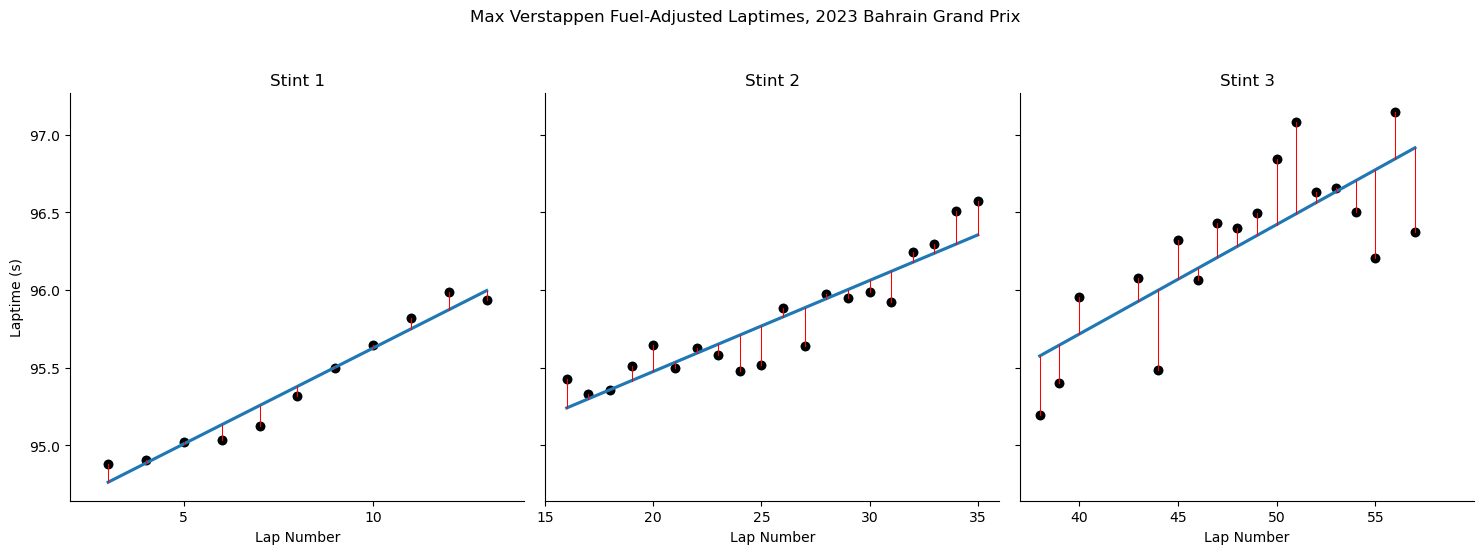

In [5]:
g = sns.lmplot(data = r1ver, x = 'lap_number', y = 'lap_time', col = 'stint', facet_kws = {'sharex' : False}, ci = None)
for i, g in enumerate(g.axes.flat):
    
    # Tidy up the x tick marks as seaborn would otherwise display decimals for lap_number
    if i == 0:
        g.set(xlim = (2, 14), xticks = range(5, 14, 5))
    elif i == 1:
        g.set(xlim = (15, 36), xticks = range(15, 36, 5))
    elif i == 2:
        g.set(xlim = (37, 60), xticks = range(40, 60, 5))
        
    g.scatter(r1ver['lap_number'], r1ver['lap_time'], color = 'black')
    
    # Code for displaying residual lines
    facet_data = r1ver[r1ver['stint'] == i + 1]
    slope, intercept = np.polyfit(facet_data['lap_number'], facet_data['lap_time'], 1)
    predicted_values = slope * facet_data['lap_number'] + intercept
    residuals = facet_data['lap_time'] - predicted_values
    for x, y, res in zip(facet_data['lap_number'], facet_data['lap_time'], residuals):
        g.plot([x, x], [y, y - res], color = 'red', linewidth = 0.75)
        
    # Labels and title
    g.set_xlabel('Lap Number')
    g.set_ylabel('Laptime (s)')
    g.set_title(f'Stint {i+1}')

plt.suptitle('Max Verstappen Fuel-Adjusted Laptimes, 2023 Bahrain Grand Prix', y=1.1)

Just by looking at the above graph, we can see that Max Verstappen's first stint is the most consistent, as the data points follow the linear regression line more cloesly, whereas the data points in the second and third stint are a lot more scattered.  

We can quantify these visual differences by calculating the residual variance of laptimes relative to the linear regression line.

Let x be the lap number and y be the laptime:  
$\alpha = \bar{t} - \beta\bar{x}$  
$\beta = \frac{\text{corr}(y, x) \cdot \sigma_y}{\sigma_x}$  
$\hat{y} = \alpha + \beta x$

Residual:  
$r_i = y_i - \hat{y}_i$

In [6]:
# Function for residual variance calculation
def residualsVar(df):
    x = df['lap_number']
    y = df['lap_time']
    
    # Calculate the slope and intercept of the linear regression line using the standard formulas
    slope = pd.Series(y).corr(pd.Series(x)) * (pd.Series(y).std() / pd.Series(x).std())
    intercept = y.mean() - slope * x.mean()
    
    # Determine the residuals by calculating the distance from data points to the regression line
    residuals = y - (slope * x + intercept)
    
    # Return the variance of residuals
    return residuals.var()

# Group laptime data by stints and apply the residualsVar function
stintResidualsVar = r1ver.groupby('stint').apply(residualsVar)

print(stintResidualsVar)
print(stintResidualsVar.mean())

stint
1    0.006696
2    0.021525
3    0.116354
dtype: float64
0.048191499684477196


The result of this calculation shows the lowest residual variance for stint 1 laptimes, followed by stint 2 and 3, which confirms our visual estimation.  
We can then determine Verstappen's average laptime consistency of the entire race by taking the mean of all three residual variances.  
  
Now let's include Verstappen's data for all 22 races of the year:

In [7]:
# Test our initial model on a single driver
# Create an empty dataframe
verConsistency = pd.DataFrame()

# Iterate through all 22 races of the season
for i in range(1,23):
    # Filters
    laptimes = df[(df['driver'].str.match('VER')) & 
                  (df['round'] == i) & 
                  (df['pit_in_time'].isna()) & 
                  (df['pit_out_time'].isna()) & 
                  (df['track_status'] == 1)].copy()
    
    # Group laptime data by stints and apply the residualsVar function
    stints = laptimes.groupby('stint').apply(residualsVar)
    
    # Concatenate data from each race
    verConsistency = pd.concat([verConsistency, stints], axis = 0)

# Display the mean residual variance of all race stints
print(verConsistency.mean())

0    2.658156
dtype: float64


This calculation gives us Max Verstappen's average laptime residual variance through out the entire 2023 season, which we will use to compare him with other drivers.  
Unlike in project 1, we will not be filtering laptimes completed on Intermediate and Wet tires, as wet condition consistency comes down to the driver's skill as well.

## Expand Model
We can now expand our model and apply it to every driver on the grid. To improve the accuracy of our final data, we will exclude the top 10% of residual variances of laptimes by stint for each driver.

In [8]:
# Create an empty dataframe
consistency = pd.DataFrame()

# Iterate through all drivers
for driver in df['driver'].unique():
    driverStints = pd.DataFrame()
    
    # Format the dataframe
    meanRes = pd.DataFrame(columns = ['driver', 'consistency'])
    
    # Iterate through all 22 races of the season
    for i in range(1,23):
        # Filters
        laptimes = df[(df['driver'].str.match(driver)) & 
                  (df['round'] == i) & 
                  (df['pit_in_time'].isna()) & 
                  (df['pit_out_time'].isna()) & 
                  (df['track_status'] == 1)].copy()
        
        # Group laptime data by stints and apply the residualsVar function
        stints = laptimes.groupby('stint').apply(residualsVar)
        
        # Ignore races where the driver failed to start
        if stints.shape[0] != 0:
            # Concatenate data from each race
            driverStints = pd.concat([driverStints, stints], axis = 0)
    
    # Filter for top 90% of data points
    sortedStints = driverStints.sort_values(by = driverStints.columns[0])
    outliers = int(len(sortedStints) * 0.90)
    
    # Calculate mean residual variance of top 90% data points
    meanRes['consistency'] = sortedStints.iloc[:outliers].mean()
    meanRes['driver'] = driver
    
    # Concatenate data from each driver
    consistency = pd.concat([consistency, meanRes], axis = 0)
    
print(consistency)

  driver  consistency
0    VER     0.270883
0    GAS     0.631571
0    PER     0.669884
0    ALO     0.426521
0    LEC     0.265380
0    STR     0.583153
0    SAR     0.899543
0    MAG     0.622832
0    DEV     0.823206
0    TSU     0.571128
0    ALB     0.549379
0    ZHO     0.709511
0    HUL     0.660741
0    OCO     0.743894
0    NOR     0.286816
0    HAM     0.438920
0    SAI     0.381613
0    RUS     0.458158
0    BOT     0.861176
0    PIA     0.447219
0    RIC     0.414458
0    LAW     0.482405


Sorting our table and making it more legible by adding drivers' full name and team.

In [9]:
# Create a key matching driver's abbreviation to driver's full name and team
abb = consistency['driver'].sort_values()
driverIndex = {
    'driver': abb,
    'full_name': ["Alex Albon", "Fernando Alonso", "Valtteri Bottas", "Nyck de Vries", 
                  "Pierre Gasly", "Lewis Hamilton", "Nico Hülkenberg", "Liam Lawson", 
                  "Charles Leclerc", "Kevin Magnussen", "Lando Norris", "Esteban Ocon", 
                  "Sergio Pérez", "Oscar Piastri", "Daniel Ricciardo", "George Russell", 
                  "Carlos Sainz Jr.", "Logan Sargeant", "Lance Stroll", "Yuki Tsunoda", 
                  "Max Verstappen", "Zhou Guanyu"],
    'team': ["Williams", "Aston Martin", "Alfa Romeo", "AlphaTauri", "Alpine", "Mercedes", 
             "Haas", "AlphaTauri", "Ferrari", "Haas", "McLaren", "Alpine", "Red Bull Racing", 
             "McLaren", "AlphaTauri", "Mercedes", "Ferrari", "Williams", "Aston Martin", 
             "AlphaTauri", "Red Bull Racing", "Alfa Romeo"]
}
driverIndex = pd.DataFrame(driverIndex)

# Merge raw table with the key, and sort by mean residual variance
sortedConsistency = pd.merge(consistency, driverIndex, on = 'driver').sort_values(by = consistency.columns[1])

# Rearrange index
sortedConsistency.reset_index(drop=True, inplace=True)

print(sortedConsistency)

   driver  consistency         full_name             team
0     LEC     0.265380   Charles Leclerc          Ferrari
1     VER     0.270883    Max Verstappen  Red Bull Racing
2     NOR     0.286816      Lando Norris          McLaren
3     SAI     0.381613  Carlos Sainz Jr.          Ferrari
4     RIC     0.414458  Daniel Ricciardo       AlphaTauri
5     ALO     0.426521   Fernando Alonso     Aston Martin
6     HAM     0.438920    Lewis Hamilton         Mercedes
7     PIA     0.447219     Oscar Piastri          McLaren
8     RUS     0.458158    George Russell         Mercedes
9     LAW     0.482405       Liam Lawson       AlphaTauri
10    ALB     0.549379        Alex Albon         Williams
11    TSU     0.571128      Yuki Tsunoda       AlphaTauri
12    STR     0.583153      Lance Stroll     Aston Martin
13    MAG     0.622832   Kevin Magnussen             Haas
14    GAS     0.631571      Pierre Gasly           Alpine
15    HUL     0.660741   Nico Hülkenberg             Haas
16    PER     

## Refine our result
We can now produce our final table by rearranging our columns and making our column names more display-friendly, as well as adjusting the index so it starts from 1.

In [10]:
# Make the final table more friendly
columnNames = {'full_name': 'Driver', 'team': 'Team', 'consistency': "Laptime Variation"}
table = sortedConsistency[list(columnNames.keys())].rename(columns = columnNames)

# Change the index to start from 1 for ranking
table.index += 1

table

,Driver,Team,Laptime Variation
1,Charles Leclerc,Ferrari,0.265380
2,Max Verstappen,Red Bull Racing,0.270883
3,Lando Norris,McLaren,0.286816
4,Carlos Sainz Jr.,Ferrari,0.381613
5,Daniel Ricciardo,AlphaTauri,0.414458
6,Fernando Alonso,Aston Martin,0.426521
7,Lewis Hamilton,Mercedes,0.438920
8,Oscar Piastri,McLaren,0.447219
9,George Russell,Mercedes,0.458158
10,Liam Lawson,AlphaTauri,0.482405


Visualizing our final result:

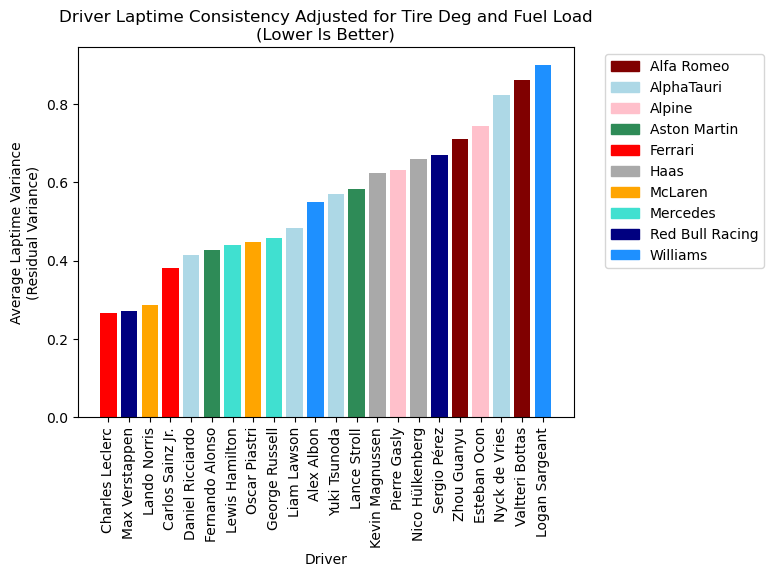

In [11]:
# Final graph with color-coded drivers and teams
colors = {'Alfa Romeo': 'maroon', 'AlphaTauri': 'lightblue','Alpine': 'pink','Aston Martin': 'seagreen',
          'Ferrari': 'red','Haas': 'darkgrey','McLaren': 'orange','Mercedes': 'turquoise',
          'Red Bull Racing': 'navy', 'Williams': 'dodgerblue'
         }

plt.bar(sortedConsistency['full_name'], sortedConsistency['consistency'], 
       color = [colors[color] for color in sortedConsistency['team']])
plt.xticks(rotation = 90)
plt.title('Driver Laptime Consistency Adjusted for Tire Deg and Fuel Load\n(Lower Is Better)')
plt.xlabel('Driver')
plt.ylabel('Average Laptime Variance\n(Residual Variance)')
legend = [plt.Rectangle((0,0),1,1, color=colors[team]) for team in colors]
plt.legend(legend, colors.keys(),bbox_to_anchor=(1.05, 1),loc='upper left')

## Conclusion
Like the tire wear comparison of Project 1, this graph does not serve as a definitive ranking of drivers' overall performance, as it does not account for the performance differences among cars from different teams. However, compared to tire wear characteristics, this consistency ranking more closely reflects a driver's skill and their confidence in the car. This is especially true when we compare drivers from the same team.  
  
Using Max Verstappen and Sergio Perez as an example, while Perez was incredible when it came to tire preservation as indicated in Project 1, he did not feel confident at all in the car compared to his teammate Max Verstappen, as the car did not suit his driving style. As a result, his laptimes were inconsistent and he delivered very mediocre results in 2023, often battling in the mid-field, and even crashing his car on a few occasions, while Max Verstappen was able to consistently maximize the performance of his car and dominate the entire season.
